# Binary Classification (Cats & Dogs) Transfer Learning Dropout

### Preparing Dataset

In [1]:
# ## Get the dataset from Kaggle - https://www.kaggle.com/c/dogs-vs-cats/data OR
# !wget --no-check-certificate \
#   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#   -O Dataset/cats_vs_dogs.zip

In [2]:
import os
import zipfile

DATASET_DIR = 'Dataset'
DATASET_ZIP = 'Dataset/cats_vs_dogs.zip'
BASE_DIR = 'Dataset/cats_vs_dogs'

if not os.path.isdir(BASE_DIR):
    os.makedirs(BASE_DIR)
    
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zipref:
        zipref.extractall(BASE_DIR)
    
BASE_DIR = os.path.join(BASE_DIR, 'cats_and_dogs_filtered')
os.listdir(BASE_DIR)

['train', 'validation', 'vectorize.py']

### Config

In [3]:
def total_count(DIR):
    cat = DIR.split('/')[-1]
    print(f"Total number of data in **{cat}** is: {len(os.listdir(DIR))}")

TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'validation')
TRAIN_CATS_DIR = os.path.join(TRAIN_DIR, 'cats')
total_count(TRAIN_CATS_DIR)
VALID_CATS_DIR = os.path.join(VALID_DIR, 'cats')
total_count(VALID_CATS_DIR)
TRAIN_DOGS_DIR = os.path.join(TRAIN_DIR, 'dogs')
total_count(TRAIN_DOGS_DIR)
VALID_DOGS_DIR = os.path.join(VALID_DIR, 'dogs')
total_count(VALID_DOGS_DIR)

Total number of data in **cats** is: 1000
Total number of data in **cats** is: 500
Total number of data in **dogs** is: 1000
Total number of data in **dogs** is: 500


### Visualizing Examples

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

def plot_samples(img_dir, rows=3, cols=3):
    plt.figure()
    f, axs = plt.subplots(rows, cols, figsize=(12, 10))
    for i in range(rows):
        for j in range(cols):
            img_path = os.path.join(img_dir, random.choice(os.listdir(img_dir)))
            img = plt.imread(img_path)
            axs[i, j].title.set_text(img_dir.split('/')[-1])
            axs[i, j].imshow(img)

<Figure size 432x288 with 0 Axes>

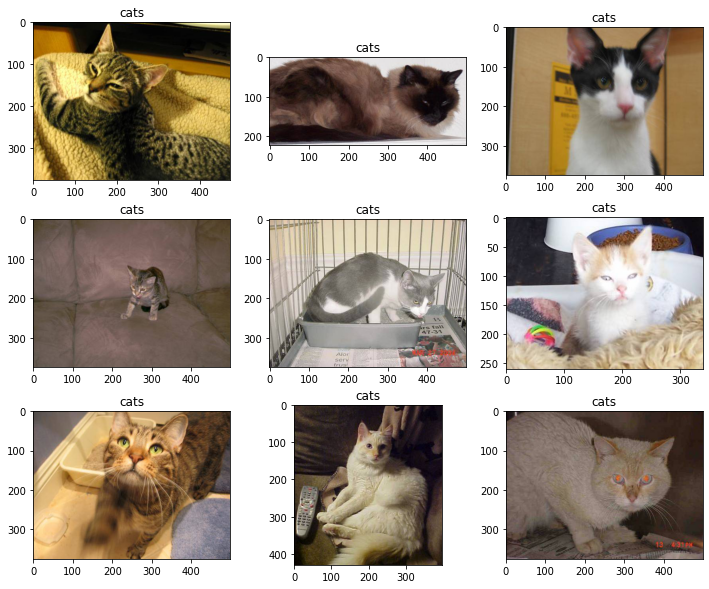

In [5]:
plot_samples(TRAIN_CATS_DIR)    

<Figure size 432x288 with 0 Axes>

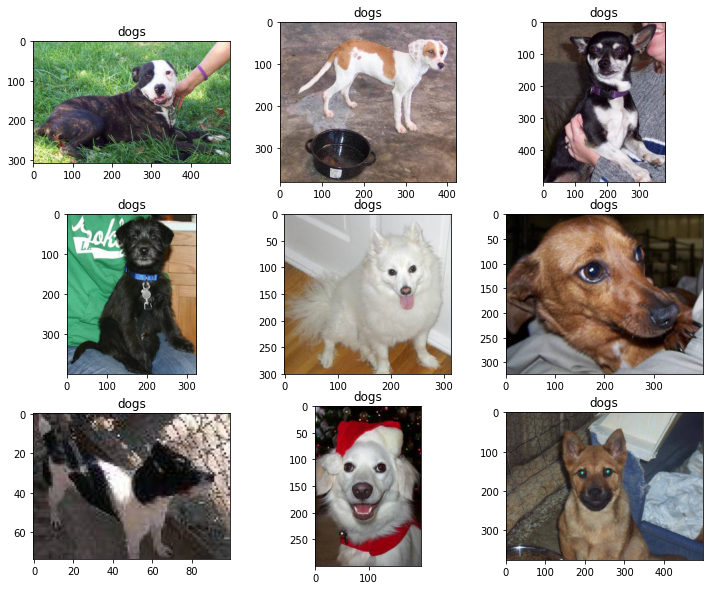

In [6]:
plot_samples(TRAIN_DOGS_DIR)    

### Build Model

In [7]:
import tensorflow as tf

In [8]:
inception_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                                weights='imagenet',
                                                                input_shape=(150,150,3)
                                                                )

In [9]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
def build_model(layer='mixed9'):
    for layer in inception_model.layers:
        layer.trainable = False

    pre_trained_layer = inception_model.get_layer('mixed9')
    print(pre_trained_layer.output_shape)
    pretrained_output = pre_trained_layer.output
    
    x1 = tf.keras.layers.Flatten()(pretrained_output)
    x2 = tf.keras.layers.Dense(256, activation='relu')(x1)
    x3 = tf.keras.layers.Dropout(0.2)(x2)
    x4 = tf.keras.layers.Dense(128, activation='relu')(x3)
    x5 = tf.keras.layers.Dropout(0.2)(x4)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x5)
    
    model = tf.keras.Model(inception_model.input, output)
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01), 
                                                      loss='binary_crossentropy',
                                                      metrics=['acc'])
    
    return model

In [11]:
model = build_model()

(None, 3, 3, 2048)


## Image DataGenerator

In [12]:
## Data Augemntation
TRAIN_DATA_GENERATOR = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                       rotation_range=20,
                                                                       width_shift_range=20,
                                                                      height_shift_range=20,
                                                                       shear_range=20,
                                                                       zoom_range=10,
                                                                       fill_mode='nearest')
VALID_DATA_GENERATOR = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

In [13]:
TRAIN_DATA_GEN = TRAIN_DATA_GENERATOR.flow_from_directory(
                    TRAIN_DIR,
                    target_size=(150,150),
                    color_mode='rgb',
                    class_mode='binary',
                    batch_size=32,
                    shuffle=True,
                    seed=123
            )

VALID_DATA_GEN = VALID_DATA_GENERATOR.flow_from_directory(
                    VALID_DIR,
                    target_size=(150,150),
                    color_mode='rgb',
                    class_mode='binary',
                    batch_size=32,
                    shuffle=False,
                    seed=123
            )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_acc', patience=5, verbose=1, restore_best_weights=True
                )

In [15]:
history = model.fit(
            TRAIN_DATA_GEN,
            batch_size=20,
            epochs=40,
            verbose=1,
            callbacks=[early_stopping],
            validation_data=VALID_DATA_GEN
            )

Epoch 1/40
63/63 [==============================] - 24s 355ms/step - loss: 9.0863 - acc: 0.5215 - val_loss: 0.6245 - val_acc: 0.5970
Epoch 2/40
63/63 [==============================] - 22s 350ms/step - loss: 0.7602 - acc: 0.5090 - val_loss: 0.6972 - val_acc: 0.7440
Epoch 3/40
63/63 [==============================] - 22s 353ms/step - loss: 0.7307 - acc: 0.5210 - val_loss: 0.5827 - val_acc: 0.8310
Epoch 4/40
63/63 [==============================] - 22s 353ms/step - loss: 0.7588 - acc: 0.5385 - val_loss: 0.4842 - val_acc: 0.5150
Epoch 5/40
63/63 [==============================] - 22s 352ms/step - loss: 0.7153 - acc: 0.5500 - val_loss: 0.2791 - val_acc: 0.9030
Epoch 6/40
63/63 [==============================] - 22s 351ms/step - loss: 0.6972 - acc: 0.5880 - val_loss: 0.4155 - val_acc: 0.8430
Epoch 7/40
63/63 [==============================] - 22s 353ms/step - loss: 0.6623 - acc: 0.6140 - val_loss: 0.2606 - val_acc: 0.9310
Epoch 8/40
63/63 [==============================] - 22s 352ms/step - 

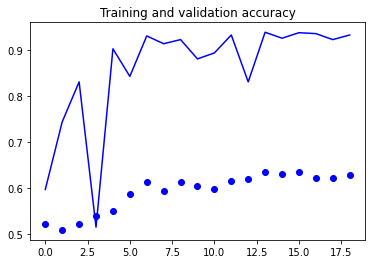

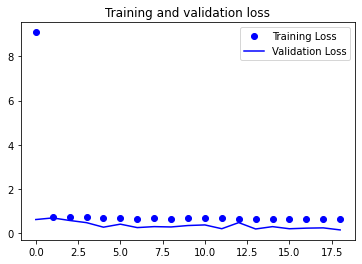

In [16]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc, 'bo', label='training accuracy')
plt.plot  ( epochs, val_acc, 'b', label='validation accuracy')
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs, loss, 'bo', label='Training Loss')
plt.plot  ( epochs, val_loss, 'b', label='Validation Loss')
plt.title ('Training and validation loss')
plt.legend()

## Inference

In [17]:
def predict_image(image_path):
    image = tf.keras.preprocessing.image.load_img(
            image_path, color_mode='rgb', target_size=(150,150))
    
    image_array = np.asarray(image)
    image_array = np.expand_dims(image_array, axis=0)
    out = model.predict(image_array)
    if out < 0.5:
        res = "cat"
    else:
        res = "dog"
    print(f"Image is: {res}")
    

In [18]:
test_img_path = "Dataset/cats_vs_dogs/cats_and_dogs_filtered/train/dogs/dog.4.jpg"
predict_image(test_img_path)

Image is: dog


# 